# Linear regression taken from Dynesty example
https://github.com/joshspeagle/dynesty/blob/master/demos/Examples%20--%20Linear%20Regression.ipynb

In [15]:


from jax import config

import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import NestedSampler
from jaxns import Model
from jaxns import Prior
from jaxns import bruteforce_evidence
import numpy as np

tfpd = tfp.distributions

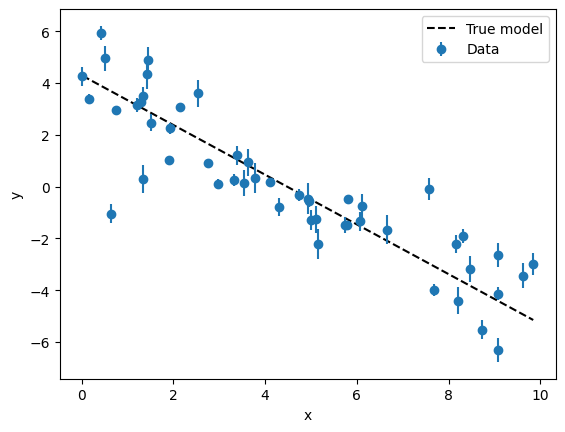

In [16]:

# truth
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# generate mock data
N = 50
x = np.sort(10 * np.random.uniform(size=N))
yerr = 0.1 + 0.5 * np.random.uniform(size=N)
y_true = m_true * x + b_true
y = y_true + np.abs(f_true * y_true) * np.random.normal(size=N)
y += yerr * np.random.normal(size=N)

plt.plot(x, y_true, 'k--', label='True model')
plt.errorbar(x, y, yerr=yerr, fmt='o', label='Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [17]:
from jax._src.scipy.special import logsumexp


def log_likelihood(m,b,lnf):
    """
    Dual moon log-likelihood.
    """
    # mean = m * x + b
    # scale = yerr * f

    model = m * x + b
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * jnp.exp(2 * lnf))

    return -0.5 * (jnp.sum((y-model)**2 * inv_sigma2 - jnp.log(inv_sigma2)))


    # dist = tfpd.Normal(mean, scale)
    # return dist.log_prob(y).sum()


def prior_model():
    # m = 5.5 * um - 5.
    # b = 10. * ub
    # lnf = 11. * ulf - 10.
    m = yield Prior(tfpd.Uniform(low=-5, high=0.5), name='m')
    b = yield Prior(tfpd.Uniform(low=0, high=10), name='b')
    lnf = yield Prior(tfpd.Uniform(low=-10, high=1), name='lnf')
    return m, b, lnf


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

log_Z_true = bruteforce_evidence(model=model, S=250)
print(f"True log(Z)={log_Z_true}")


True log(Z)=-40.15732454054357


In [18]:


# Create the nested sampler class. In this case without any tuning.
ns = NestedSampler(model=model)

termination_reason, state = ns(random.PRNGKey(42))
results = ns.to_results(termination_reason=termination_reason, state=state)


In [19]:
# We can use the summary utility to display results
ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 129552
samples: 1440
phantom samples: 0
likelihood evals / sample: 90.0
phantom fraction (%): 0.0%
--------
logZ=-39.95 +- 0.37
max(logL)=-29.43
H=-9.05
ESS=132
--------
b: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
b: 3.81 +- 0.3 | 3.48 / 3.74 / 4.27 | 3.73 | 3.73
--------
lnf: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
lnf: -0.66 +- 0.12 | -0.8 / -0.66 / -0.51 | -0.66 | -0.66
--------
m: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
m: -0.895 +- 0.074 | -0.995 / -0.889 / -0.808 | -0.877 | -0.877
--------


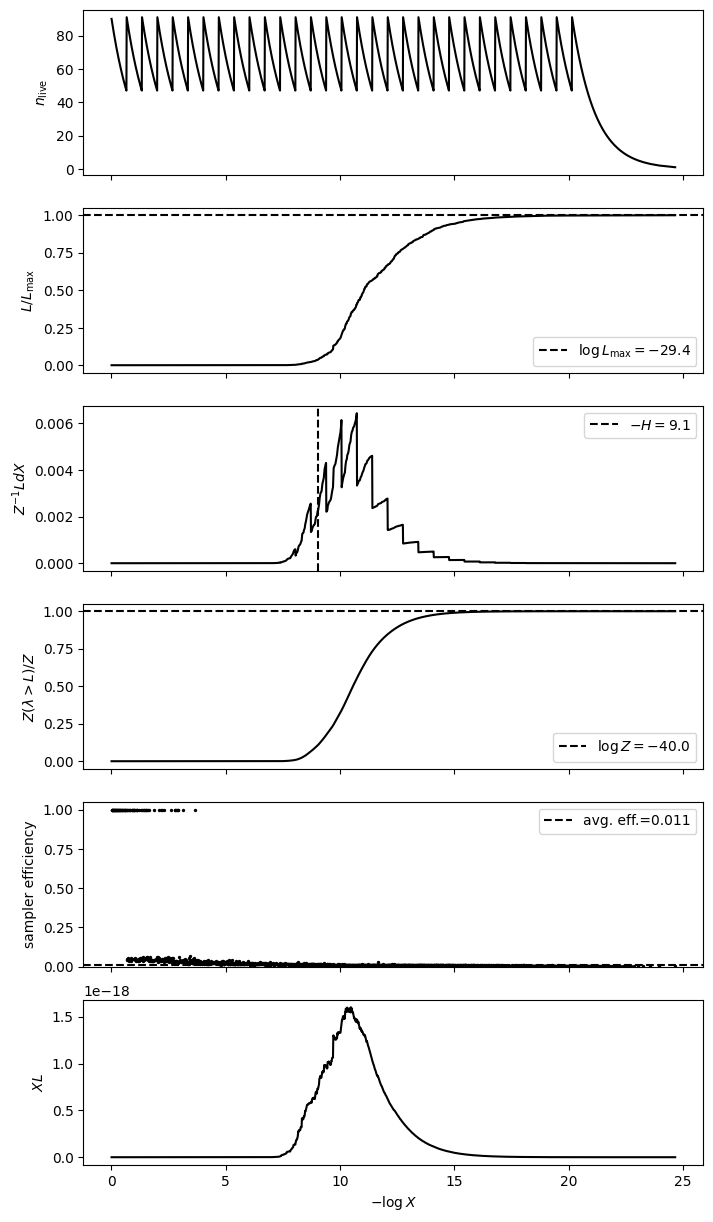

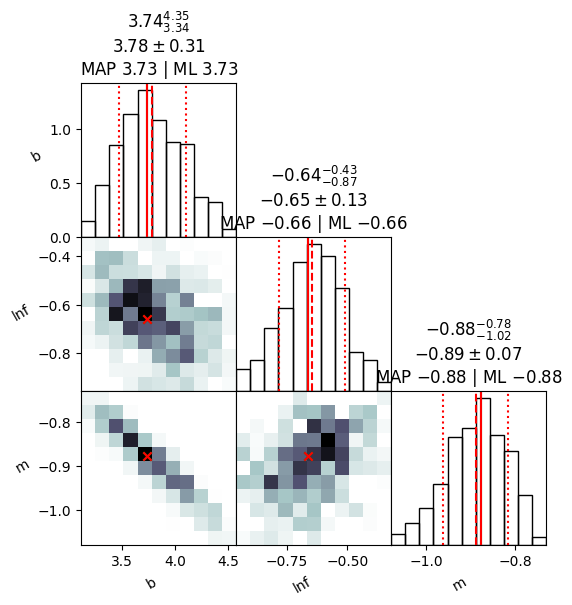

In [20]:
# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)